In [1]:
import re
import json
import shap
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from joblib import Parallel, delayed

from scipy.stats import spearmanr
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

### Logistic Regression for Feature Importance

In [5]:
def get_status(answer, modes):
    if len(modes) == num_opt: return 'Absent'
    if len(modes) == 1:
        if modes[0] == answer: return 'Consistent Correct'
        else: return 'Consistent Wrong'
    if answer in modes: return 'Conflicting Correct'
    else: return 'Conflicting Wrong'

def get_results(data, abbre2model):
    dataset = pd.read_csv(f'Data/Input/{data}.csv')
    idx2answer = {idx:answer for idx, answer in enumerate(dataset['answer'])}
    model2memory, model2context = {}, {}
    for abbre, model in abbre2model.items():
        idx2modes = json.load(open(f'Data/Status/{data}/{model}.json'))
        model2memory[abbre] = [get_status(idx2answer[int(idx)], modes['memory']) for idx, modes in idx2modes.items()]
        model2context[abbre] = [get_status(idx2answer[int(idx)], modes['context']) for idx, modes in idx2modes.items()]
    return model2memory, model2context

num_opt = 3
versions = ['memory', 'context']
statuses = ['Consistent Correct', 'Conflicting Correct', 'Absent', 'Conflicting Wrong', 'Consistent Wrong']
datas = ['Hemonc', 'PubMedQA', 'NQ', 'HotpotQA']
abbre2model = {'Gemma-2B':'gemma-2-2b-it', 'Gemma-9B':'gemma-2-9b-it', 'Gemma-27B':'gemma-2-27b-it', 
               'Llama-3B':'Llama-3.2-3B-Instruct', 'Llama-8B':'Llama-3.1-8B-Instruct', 'Llama-70B':'Llama-3.3-70B-Instruct', 
               'Qwen-3B':'Qwen2.5-3B-Instruct', 'Qwen-7B':'Qwen2.5-7B-Instruct', 'Qwen-14B':'Qwen2.5-14B-Instruct'}

data2model2memory, data2model2context = {}, {}
for data in datas:
    data2model2memory[data], data2model2context[data] = get_results(data, abbre2model)
data2features = {data:pd.read_csv(f'Data/Feature/{data}.csv') for data in datas}

In [6]:
def preprocess(source_status, data, model):    
    features, labels = [], []
    for idx, row in data2features[data].iterrows():
        memory_status, context_status = data2model2memory[data][model][idx], data2model2context[data][model][idx]
        if memory_status != source_status: continue
        features.append(row[feature_columns+feature_columns_model(model)].to_list())
        labels.append(context_status == target_status)
    features, labels = np.array(features), np.array(labels)
    if len(labels) < 50 or len(np.where(~labels)[0]) < 10: return None    
    feature_train, feature_test, label_train, label_test = train_test_split(features, labels, stratify=labels, test_size=0.2, random_state=seed)
    scaler = StandardScaler()
    scaler.fit(feature_train)
    feature_train = scaler.transform(feature_train)
    feature_test = scaler.transform(feature_test)
    return feature_train, feature_test, label_train, label_test

def classify(feature_train, feature_test, label_train, label_test):
    clf = LogisticRegression(penalty="l2", solver="saga", max_iter=10000, random_state=seed)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    grid_search = GridSearchCV(estimator=clf, cv=cv, param_grid=param_grid, scoring="f1_macro", n_jobs=n_jobs)
    grid_search.fit(feature_train, label_train)
    best_model = grid_search.best_estimator_
    label_pred = best_model.predict(feature_test)
    score = f1_score(label_test, label_pred, average='macro')
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(feature_train, label_train)
    label_dummy = dummy.predict(feature_test)
    baseline = f1_score(label_test, label_dummy, average='macro')
    return best_model, (score, baseline)

In [7]:
seed = 42
target_status = 'Consistent Correct'
feature_columns = ['Length', 'Readability', '# Uniq Tkns', 'Emb Sim'] + [f'rouge2-{n}' for n in ['P', 'R', 'F']]
feature_columns_model = lambda m: [f'{m} {f} {k}' if m else f'{f} {k}' for f in ['Perp', 'Entr'] for k in ['Context', 'Question']]
param_grid = {"class_weight": [None, "balanced", {0:2,1:1}, {0:5,1:1}, {0:10,1:1}],
              "C": [0.01, 0.1, 1.0, 10.0]}

remove_warn = lambda: warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_jobs = 10
remove_warn()
Parallel(n_jobs=n_jobs)(delayed(remove_warn)() for _ in range(n_jobs))

combi2input, combi2model, combi2score = {}, {}, {}
for source_status in statuses:
    with tqdm(total=len(datas)*len(abbre2model), desc=source_status) as pbar:
        for data in datas:
            for model in abbre2model:
                combi = (source_status, data, model)
                combi2input[combi] = preprocess(*combi)
                if combi2input[combi]: combi2model[combi], combi2score[combi] = classify(*combi2input[combi])
                pbar.update(1)

Consistent Wrong: 100%|████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:40<00:00,  2.79s/it]


### Regression Results

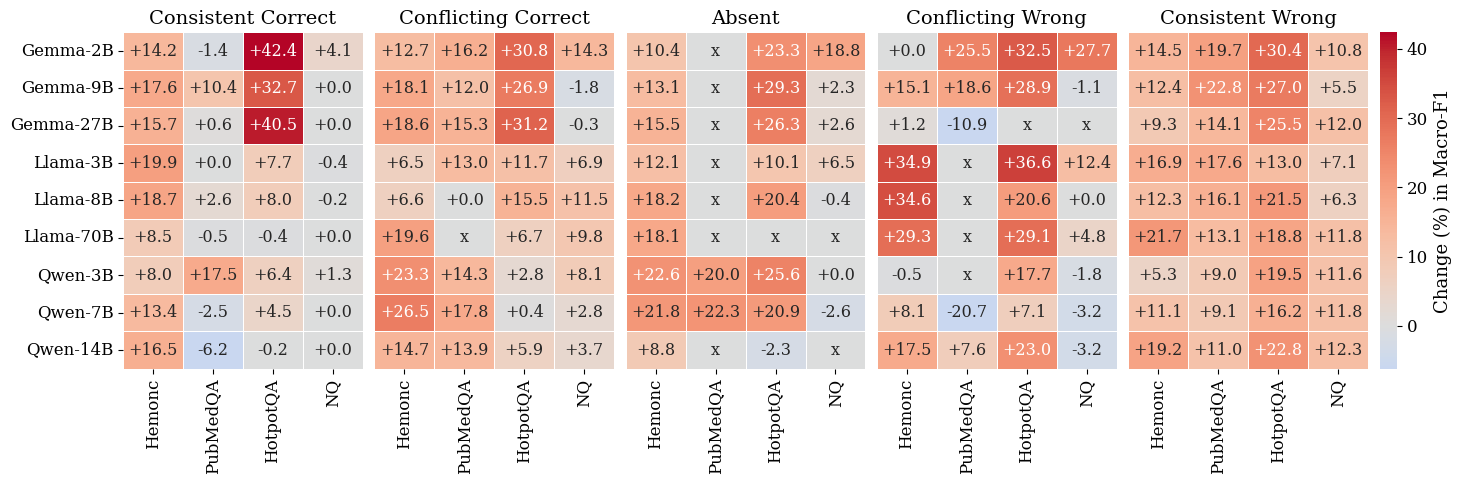

In [8]:
status2change = {}
for status in statuses:
    status2change[status] = np.full((len(abbre2model), len(datas)), np.nan)
    for mid, model in enumerate(abbre2model):
        for did, data in enumerate(datas):
            combi = (status, data, model)
            if combi in combi2score:
                score, baseline = combi2score[combi]
                status2change[status][mid, did] = score - baseline

vmin = min(change.min() for change in status2change.values())*100
vmax = max(change.max() for change in status2change.values())*100

fontsize = 12 # 10.5
num_col, num_row = len(statuses), 1
sub_col, sub_row = len(datas), len(abbre2model)
size_col, size_row = 0.725, 0.525
fig, axs = plt.subplots(num_row, num_col, constrained_layout=True, gridspec_kw={'wspace':0.04},
                        figsize=(num_col*sub_col*size_col, num_row*sub_row*size_row))

for sid, status in enumerate(statuses):
    change = np.where(np.isnan(status2change[status]), 0, status2change[status])
    annot = [['x' if np.isnan(entry) else f'{entry*100:+.1f}' for entry in row] for row in status2change[status]]
    sns.heatmap(100*change, ax=axs[sid], linewidth=0.5, vmin=vmin, vmax=vmax, 
                yticklabels=sid==0, annot=annot, fmt='s', annot_kws={'fontsize':fontsize-0.5}, center=0,
                cmap="coolwarm", cbar=sid==len(statuses)-1, 
                cbar_kws={'label':'Change (%) in Macro-F1'})
    axs[sid].set_title(status, fontsize=fontsize+2)
    axs[sid].set_xticklabels(['Hemonc', 'PubMedQA', 'HotpotQA', 'NQ'], fontsize=fontsize, 
                             ha='right', va='center', rotation=90, rotation_mode="anchor")

axs[0].set_yticklabels(abbre2model.keys(), rotation=0, ha='right', va='center', fontsize=fontsize)

cbar = axs[-1].collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.yaxis.label.set_size(fontsize+1)
    
# plt.savefig(f'Figure/regression.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

### Top-5 Feature Ranking

In [9]:
top_n = 5
fid2fea = {fid:fea for fid, fea in enumerate(feature_columns+feature_columns_model(''))}
status2valid, status2freq = defaultdict(int), defaultdict(lambda: defaultdict(int))
for status in statuses:
    for data in datas:
        for model in abbre2model:
            combi = (status, data, model)
            if combi in combi2model:
                score, baseline = combi2score[combi]
                if score > baseline:
                    status2valid[status] += 1
                    model = combi2model[combi]
                    feature_train, feature_test, label_train, label_test = combi2input[combi]
                    explainer = shap.LinearExplainer(model, feature_train)
                    shap_values = explainer.shap_values(feature_test)
                    fids = np.argsort(-np.abs(shap_values).mean(0))[:top_n]
                    for fid in fids:
                        status2freq[status][fid2fea[fid]] += 1

for status in statuses:
    status2freq[status] = {fea:freq/status2valid[status] for fea, freq in sorted(status2freq[status].items(), key=lambda x:x[1], reverse=True)}
    fea_freq = [f'{fea}: {freq:.3f}' for fea, freq in status2freq[status].items() if freq >= 0.5]
    print(status + '\n' + ' | '.join(fea_freq) + '\n' + '-'*20)
    
fea2fid = {fea:fid for fid, fea in fid2fea.items()}
status2rank = {status:[0]*len(fid2fea) for status in statuses}
for status in statuses:
    for rank, fea in enumerate(status2freq[status]):
        status2rank[status][fea2fid[fea]] = rank
        
n_tests = len(list(itertools.combinations(statuses, 2)))
alpha = 0.05 / n_tests
print()
print(f'Sig Level = {alpha:.3f} after Bonferroni Correction')

for (s1, s2) in itertools.combinations(statuses, 2):
    rho, pval = spearmanr(status2rank[s1], status2rank[s2])
    print(f'{s1:20s} and {s2:20s} | cor = {rho:.3f} | p-value = {pval:.3f}')

Consistent Correct
Entr Context: 0.727 | rouge2-R: 0.727 | # Uniq Tkns: 0.636 | Length: 0.636 | Entr Question: 0.545 | Emb Sim: 0.500
--------------------
Conflicting Correct
# Uniq Tkns: 0.625 | Emb Sim: 0.594 | Entr Context: 0.531 | Length: 0.531
--------------------
Absent
Length: 0.727 | # Uniq Tkns: 0.727 | Entr Context: 0.682 | Entr Question: 0.545 | rouge2-R: 0.545
--------------------
Conflicting Wrong
# Uniq Tkns: 0.714 | Entr Context: 0.619 | Length: 0.571 | Emb Sim: 0.524 | rouge2-P: 0.524
--------------------
Consistent Wrong
Length: 0.556 | Emb Sim: 0.528 | Entr Question: 0.528 | Entr Context: 0.528 | rouge2-P: 0.500 | rouge2-R: 0.500
--------------------

Sig Level = 0.005 after Bonferroni Correction
Consistent Correct   and Conflicting Correct  | cor = 0.809 | p-value = 0.003
Consistent Correct   and Absent               | cor = 0.791 | p-value = 0.004
Consistent Correct   and Conflicting Wrong    | cor = 0.718 | p-value = 0.013
Consistent Correct   and Consistent Wrong 

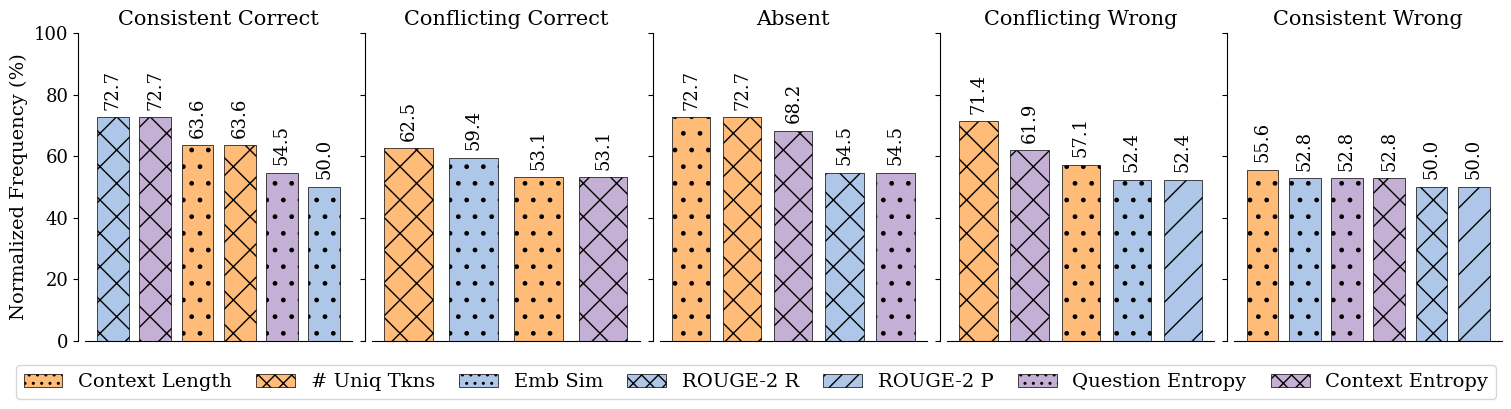

In [10]:
status2freq_clip = {
    'Consistent Correct': {'ROUGE-2 R':0.727, 'Context Entropy':0.727, 'Context Length':0.636, '# Uniq Tkns':0.636, 'Question Entropy':0.545, 'Emb Sim':0.500},
    'Conflicting Correct': {'# Uniq Tkns':0.625, 'Emb Sim':0.594, 'Context Length':0.531, 'Context Entropy':0.531},
    'Absent': {'Context Length':0.727, '# Uniq Tkns':0.727, 'Context Entropy':0.682, 'ROUGE-2 R':0.545, 'Question Entropy':0.545},
    'Conflicting Wrong': {'# Uniq Tkns':0.714, 'Context Entropy':0.619, 'Context Length':0.571, 'Emb Sim':0.524, 'ROUGE-2 P':0.524},
    'Consistent Wrong': {'Context Length':0.556, 'Emb Sim':0.528, 'Question Entropy':0.528, 'Context Entropy':0.528, 'ROUGE-2 R':0.500, 'ROUGE-2 P':0.500}
}
statuses = status2freq_clip.keys()
    
fontsize = 14
width, lw = 0.75, 0.5
colors = sns.color_palette("tab20")
feature2color = {'Context Length':colors[3], '# Uniq Tkns':colors[3],
                 'Emb Sim':colors[1], 'ROUGE-2 R':colors[1], 'ROUGE-2 P':colors[1],
                 'Question Entropy':colors[9], 'Context Entropy':colors[9]}
feature2hatch = {'Context Length':'.', '# Uniq Tkns':'x',
                 'Emb Sim':'.', 'ROUGE-2 R':'x', 'ROUGE-2 P':'/',
                 'Question Entropy':'.', 'Context Entropy':'x'}

num_row, num_col = 1, 5
size_row, size_col = 3.5, 3
fig, axs = plt.subplots(num_row, num_col, figsize=(num_col*size_col, num_row*size_row), 
                        constrained_layout=True, sharey=True)

for sid, status in enumerate(statuses):
    sns.despine(ax=axs[sid], offset=dict(left=5))
    axs[sid].set_ylim(top=100, bottom=0)
    axs[sid].set_yticks(np.linspace(0,100,6))
    axs[sid].tick_params(axis='both', which='major', labelsize=fontsize-1, labelbottom=False, bottom=False)
    axs[sid].set_title(status, fontsize=fontsize+1)
    
    feas, freqs = status2freq_clip[status].keys(), np.array(list(status2freq_clip[status].values()))
    color, hatch = [feature2color[fea] for fea in feas], [feature2hatch[fea] for fea in feas]
    axs[sid].bar(range(len(feas)), freqs*100, label=feas, width=width, color=color, hatch=hatch, edgecolor='black', lw=lw)
    for fid, freq in enumerate(freqs):
        axs[sid].text(fid, (freq+0.025)*100, f'{freq*100:.1f}', fontsize=fontsize-1, ha='center', va='bottom', rotation='vertical')
    
axs[0].set_ylabel('Normalized Frequency (%)', fontsize=fontsize)
labels = feature2hatch.keys()
handles = [Patch(facecolor=feature2color[fea], edgecolor='black', hatch=feature2hatch[fea]*2, lw=lw) for fea in labels]
fig.legend(handles, labels, fontsize=fontsize, ncol=len(feature2color), columnspacing=1.25,
           bbox_to_anchor=(0.5,0), loc='upper center', bbox_transform=fig.transFigure)

# plt.savefig('Figure/top_feature.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

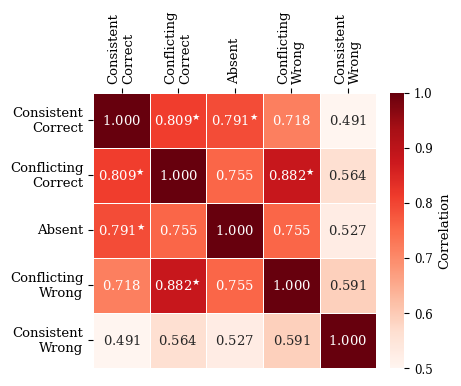

In [13]:
statuses2corrlations = {
    ('Consistent\nCorrect', 'Conflicting\nCorrect'): (0.809, 0.003),
    ('Consistent\nCorrect', 'Absent'): (0.791, 0.004),
    ('Consistent\nCorrect', 'Conflicting\nWrong'): (0.718, 0.013),
    ('Consistent\nCorrect', 'Consistent\nWrong'): (0.491, 0.125),
    ('Conflicting\nCorrect', 'Absent'): (0.755, 0.007),
    ('Conflicting\nCorrect', 'Conflicting\nWrong'): (0.882, 0.000),
    ('Conflicting\nCorrect', 'Consistent\nWrong'): (0.564, 0.071),
    ('Absent', 'Conflicting\nWrong'): (0.755, 0.007),
    ('Absent', 'Consistent\nWrong'): (0.527, 0.096),
    ('Conflicting\nWrong', 'Consistent\nWrong'): (0.591, 0.056),
}
statuses2corrlations = {tuple(sorted(k)):v for k,v in statuses2corrlations.items()}
statuses = [status.replace(' ', '\n') for status in statuses]

adj_alpha = 0.05 / len(statuses2corrlations)
correlations = np.ones((len(statuses), len(statuses)))
annotations = [['1.000$^{}$' for _ in range(len(statuses))] for _ in range(len(statuses))]
for i, status1 in enumerate(statuses):
    for j, status2 in enumerate(statuses):
        if status1 != status2:
            corr, pvalue = statuses2corrlations[tuple(sorted((status1, status2)))]
            correlations[i,j] = corr
            annotations[i][j] = f'{corr:.3f}'
            annotations[i][j] += '$^{\u2605}$' if pvalue <= adj_alpha else '$^{}$'
            
fontsize = 9.5
num_col, num_row = 1, 1
sub_col, sub_row = len(statuses), len(statuses)
size_col, size_row = 0.6*1.5, 0.5*1.5
fig, ax = plt.subplots(num_row, num_col, constrained_layout=True,
                       figsize=(num_col*sub_col*size_col, num_row*sub_row*size_row))

sns.heatmap(correlations, ax=ax, linewidth=0.5, vmin=0.5, vmax=1.0,
            annot=annotations, fmt="s", annot_kws={'fontsize':fontsize},
            cmap="Reds", cbar_kws={'label':'Correlation'})
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticklabels(statuses, fontsize=fontsize, ha='left', va='center', rotation=90, rotation_mode="anchor")
ax.set_yticklabels(statuses, fontsize=fontsize, ha='right', va='center', rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize-1)
cbar.ax.yaxis.label.set_size(fontsize)

# plt.savefig(f'Figure/rank_corr.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)